utilizo capas convTranspose para el generador
+ nuevo loop + optimizaciones
+ no normalizo ni hago transf log

In [ ]:
#pip install matplotlib

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, LeakyReLU, Reshape, UpSampling2D, ReLU, Cropping2D, Conv2DTranspose 
from keras.initializers import RandomNormal


from sklearn.model_selection import train_test_split



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
d_in_shape =  (30,30,1)



d_lr = 0.000005
d_beta1 = 0.5
d_loss = 'binary_crossentropy'
d_metrics = ['accuracy']


# modelo discriminador model_d
model_d = Sequential() 

model_d.add(Conv2D(32, (4, 4), strides=(1, 1), padding='same', input_shape=d_in_shape,  
                   kernel_initializer=RandomNormal(seed=1337), bias_initializer='zeros'))
 
model_d.add(LeakyReLU(alpha=0.2))

model_d.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                   kernel_initializer=RandomNormal(seed=1337), bias_initializer='zeros'))
 
model_d.add(LeakyReLU(alpha=0.2))

model_d.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same',
                   kernel_initializer=RandomNormal(seed=1337), bias_initializer='zeros'))
 
model_d.add(LeakyReLU(alpha=0.2))

model_d.add(Conv2D(256, (4, 4), strides=(2, 2), padding='same',
                   kernel_initializer=RandomNormal(seed=1337), bias_initializer='zeros'))
 
model_d.add(LeakyReLU(alpha=0.2))

model_d.add(Flatten())

model_d.add(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(seed=1337),
                  bias_initializer='zeros'))
 
 

  

opt_d = Adam(learning_rate=d_lr, beta_1=d_beta1) 
model_d.compile(loss=d_loss, optimizer=opt_d, metrics=d_metrics)  
  
model_d.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 32)        544       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)        32832     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 256)        

In [ ]:
# parámetros característicos de la red neural del generador:

g_input_length= 100 # longitud del espacio latente

#modelo generador model_g
model_g = Sequential()

n_nodes = 256 * 4 * 4 

model_g.add(Dense(n_nodes, input_dim=g_input_length, kernel_initializer=RandomNormal(seed=1337),
                bias_initializer='zeros'))
 
model_g.add(Reshape((4, 4, 256)))


 
model_g.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same',kernel_initializer=RandomNormal(seed=1337), 
                 bias_initializer='zeros'))
 
model_g.add(BatchNormalization())
 
model_g.add(ReLU())


 
model_g.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(seed=1337),
                  bias_initializer='zeros'))
 
model_g.add(BatchNormalization())
 
model_g.add(ReLU())


 
model_g.add(Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(seed=1337),
                 bias_initializer='zeros'))
 
model_g.add(BatchNormalization())
 
model_g.add(ReLU())

model_g.add(Cropping2D([1,1]))

model_g.add(Conv2D(1, (4, 4), strides=(1, 1), padding='same', kernel_initializer=RandomNormal(seed=1337), 
                 bias_initializer='zeros'))
 
# model_g.add(ReLU())

# model_g.add(Sigmoid()) 

model_g.summary()

#Conv2DTranspose()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 16, 16, 64)        131136    
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 64)       

In [ ]:


g_lr = 0.00004
g_beta1 = 0.5
g_loss = 'binary_crossentropy'
g_metrics = ['accuracy']

# make weights in the discriminator not trainable
model_d.trainable = False


gan = Sequential()
 
# add generator
gan.add(model_g)
 
# add the discriminator
gan.add(model_d)
 



# compile model
opt_gan = Adam(learning_rate=g_lr, beta_1=g_beta1)

gan.compile(loss=g_loss, optimizer=opt_gan, metrics=g_metrics)
 
gan.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 30, 30, 1)         1103457   
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 693217    
Total params: 1,796,674
Trainable params: 1,103,009
Non-trainable params: 693,665
_________________________________________________________________


INSPECCIÓN DE LOS DATOS- PRIMERA VISUALIZACIÓN



PREPARAR LOS DATOS PARA EL DISCRIMINADOR Y GENERAR RUIDO PARA EL GENERADOR

In [ ]:
energy_grids= np.load('/content/drive/MyDrive/energy_grids.npy')

# print(a[0].shape)
# print(energy_grids[0])

In [ ]:
energy_grids.shape[0]

50000

In [ ]:
# GENERADOR



mu=0
sigma=1
noise=[]
    
for i in range(energy_grids.shape[0]):
    noise.append(np.random.normal(mu,sigma,g_input_length).tolist())

    
    
noise = np.asarray(noise)



g_input_data = noise 
d_input_data = energy_grids 





        
        

simplemente compila la mayoría de las cosas anteriores en una función que puede llamar en el script de entrenamiento y pasar a los cargadores de datos de tensorflow, incluida la división de tren / prueba

In [ ]:


def plot_energy_grids(energy_grids_to_plot, rows=3, columns=3, name=""):

    
    fig=plt.figure(figsize=(12, 12))
    
    for i in range(1, columns*rows +1):
        
        fig.add_subplot(rows, columns, i)
        plt.imshow(energy_grids_to_plot[i].reshape((30, 30)))
        
        #plt.savefig(outputs_path + "images/" + name)
        
    plt.show()     


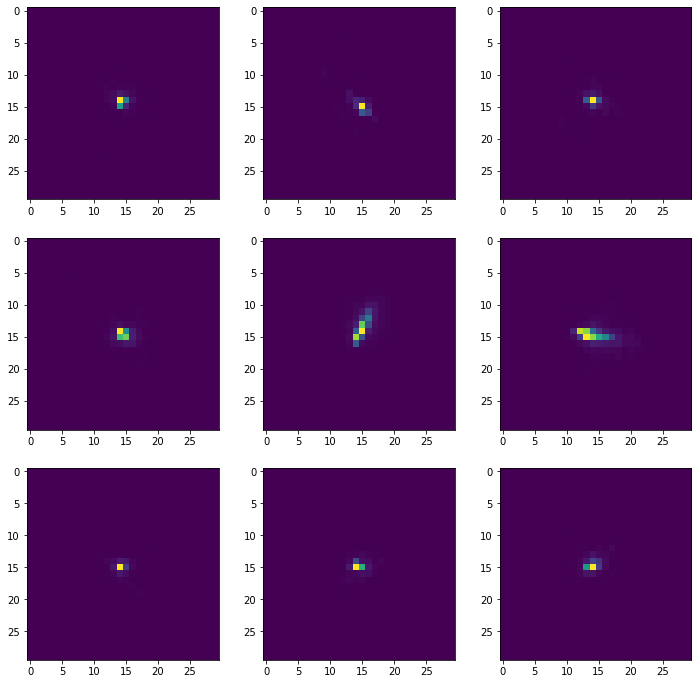

In [ ]:

plot_energy_grids(d_input_data, name="_real_images")

In [ ]:
d_input_data[0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00,

In [ ]:
noise.shape



(50000, 100)

In [ ]:
print(noise[1])

[-0.39754331 -0.69866212 -1.60089899  0.4357893  -0.12536247 -1.02015565
  0.00644861 -0.91909135 -0.48892386  0.93758083  1.1992813   0.03348072
  1.87803469 -0.11939396  0.49458315 -0.68849817  1.07211986  0.33194427
 -0.47081896  0.81916949  0.52866372 -0.59608892 -0.47610402  1.70123988
  1.08287219 -0.08825936  0.51037516  1.5042019   0.63636824 -0.43241773
 -1.01566785 -1.06760282 -0.53435794 -0.4481514  -0.89259877 -0.21455746
  0.36136771 -0.55817488  0.69765094  1.81193112 -0.77281277  0.044647
 -0.63629279 -0.14470636 -0.23067925 -0.04295638 -1.33015649 -0.24753384
  1.02231101 -1.41631855  0.32624333  0.03516704 -1.41632665 -1.35559395
 -0.58423144 -2.18453582  1.14086131 -0.17396259 -1.06909615 -0.30941019
 -1.44347402  0.78312916  0.10462227 -0.90915214  1.45979732 -1.69334155
 -1.36783437  0.88721574 -0.68158403  2.30227219 -0.15103638  1.05621933
 -0.20428472  0.58337585  1.21966195 -1.12209683 -0.19272882 -1.25219793
 -0.75221361  0.44060675  1.28799553  0.41459838  1.0

In [ ]:
train_g_input_data, test_g_input_data, train_d_input_data, test_d_input_data = \
    train_test_split(g_input_data, d_input_data, test_size=0.15, random_state=314159)


In [ ]:
def format_images(image):
    
    image = np.expand_dims(image, axis=-1)
    
    # convert from unsigned ints to floats
    image = image.astype('float32')
    # scale from [0,255] to [0,1]
    #image = image / 255.0
    
    return image

In [ ]:

train_d_input_data = format_images(train_d_input_data)
test_d_input_data = format_images(test_d_input_data)


train_g_input_data = train_g_input_data.reshape(train_d_input_data.shape[0], g_input_length)
test_g_input_data = test_g_input_data.reshape(test_d_input_data.shape[0], g_input_length)

train_g_input_data = train_g_input_data.reshape(42500, g_input_length)
test_g_input_data = test_g_input_data.reshape(7500,g_input_length)

TRAINING

Entrenamiento de la red neuronal

Starting epoch  0
664/664 [==============================] - 22s 32ms/step - loss: 0.4002 - accuracy: 0.9200


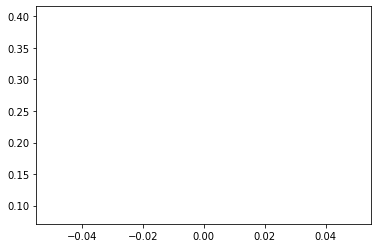

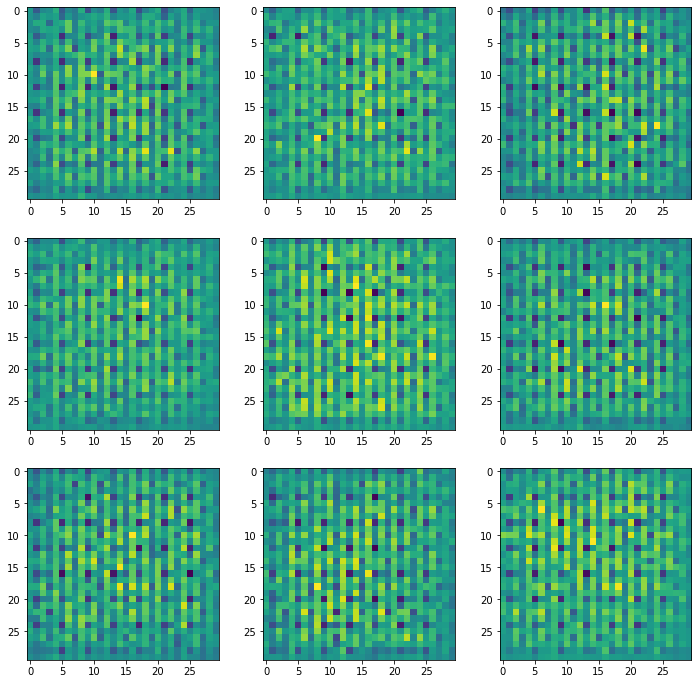

Starting epoch  1
664/664 [==============================] - 21s 32ms/step - loss: 0.7506 - accuracy: 0.6634


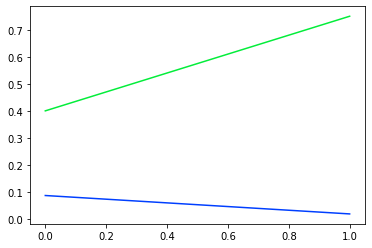

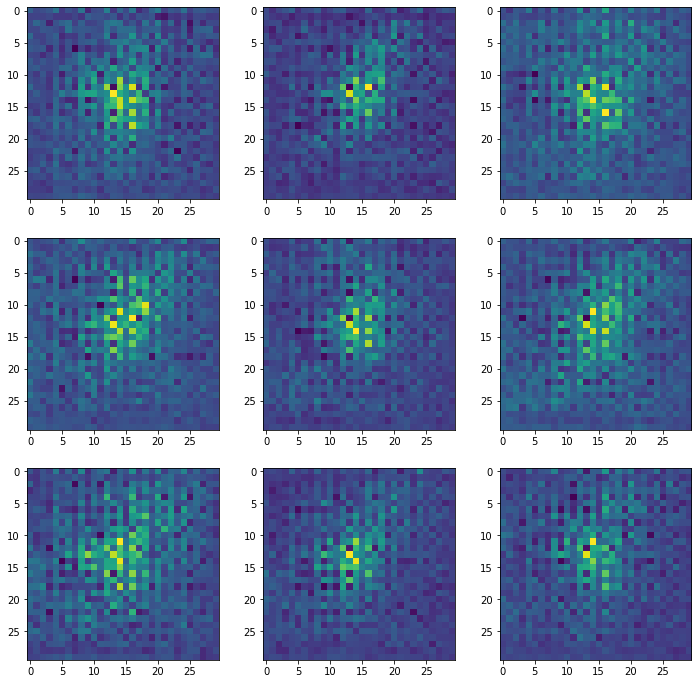

Starting epoch  2
664/664 [==============================] - 21s 32ms/step - loss: 0.5937 - accuracy: 0.7367


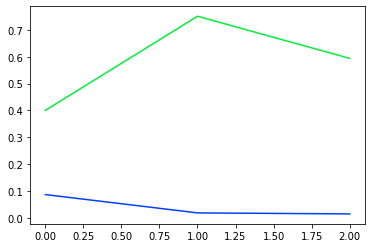

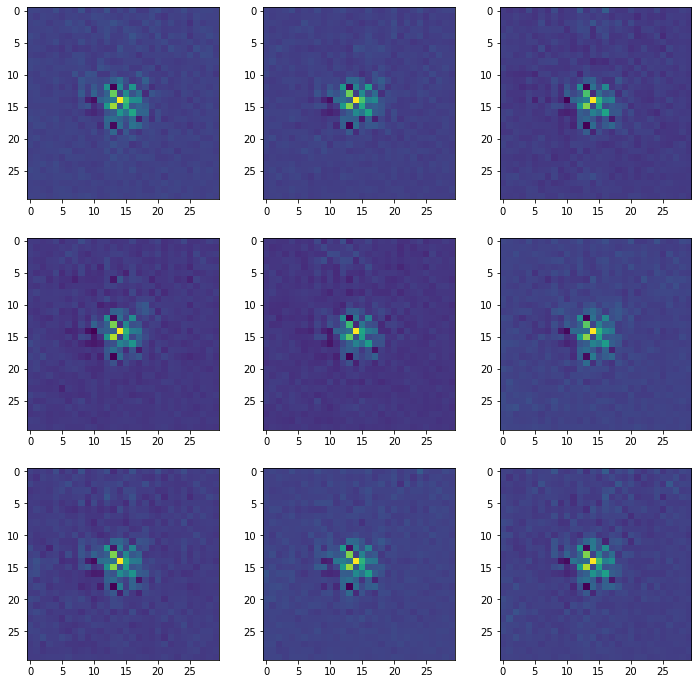

Starting epoch  3
664/664 [==============================] - 22s 32ms/step - loss: 0.3777 - accuracy: 0.8748


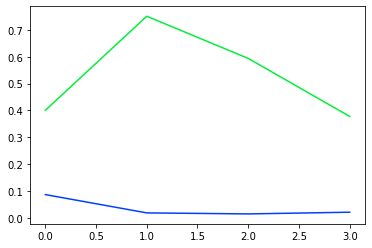

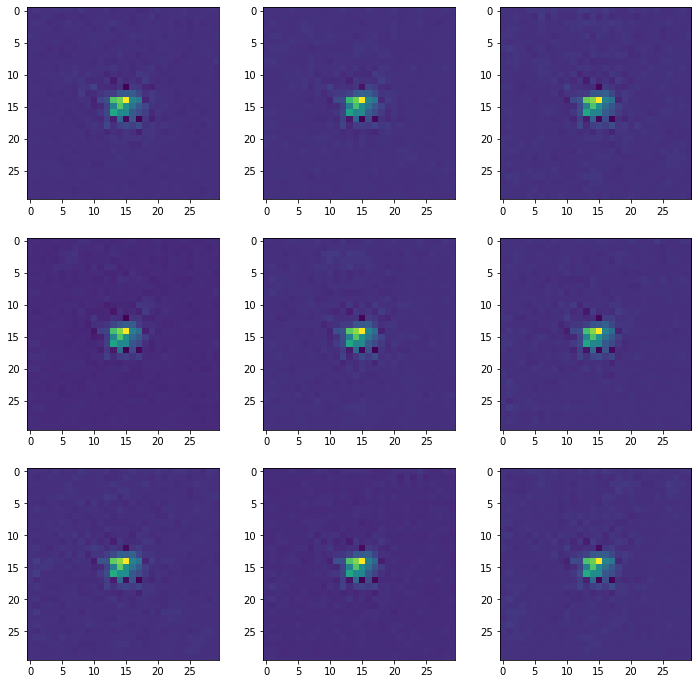

Starting epoch  4
664/664 [==============================] - 22s 32ms/step - loss: 0.2967 - accuracy: 0.8962


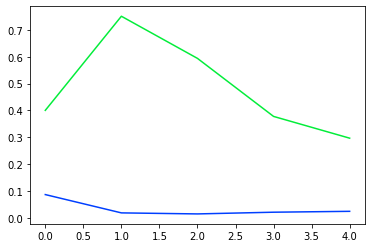

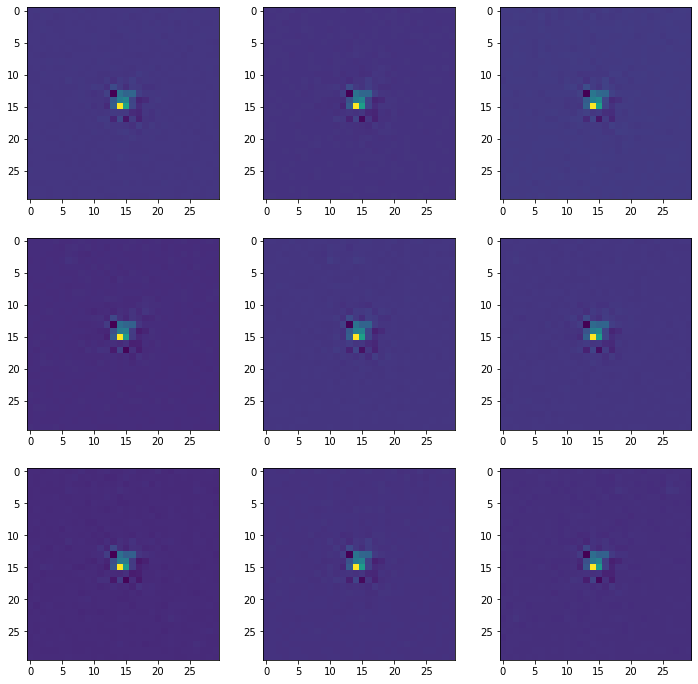

Starting epoch  5
664/664 [==============================] - 21s 32ms/step - loss: 0.2546 - accuracy: 0.9170


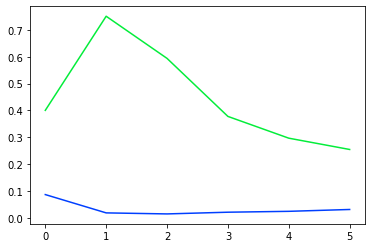

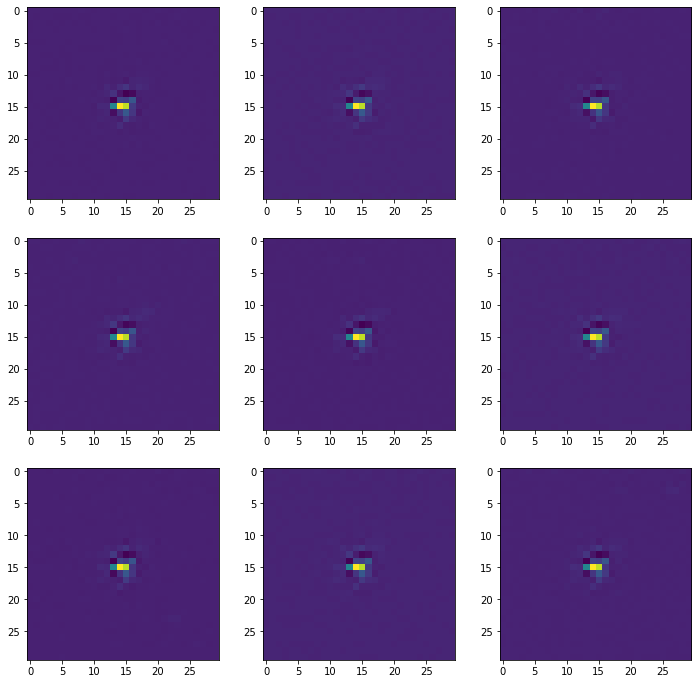

Starting epoch  6
664/664 [==============================] - 22s 33ms/step - loss: 0.1122 - accuracy: 0.9659


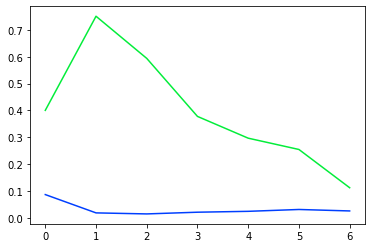

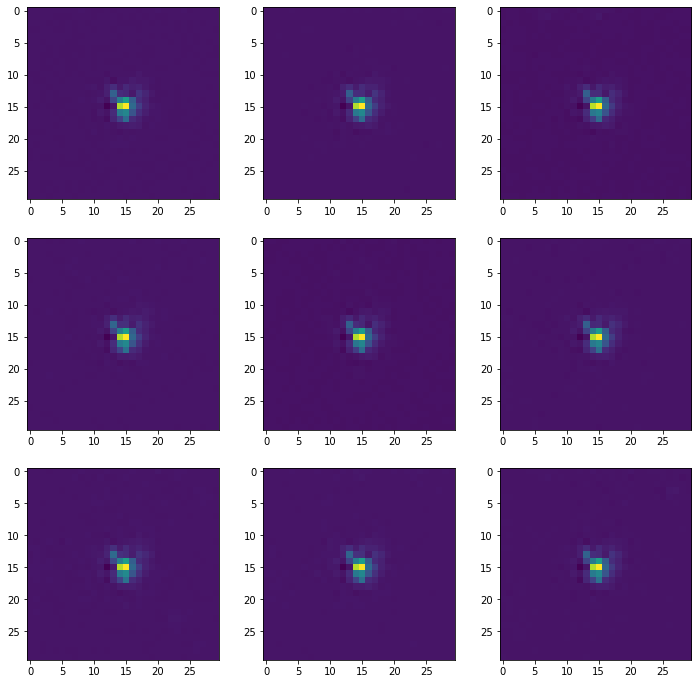

Starting epoch  7
664/664 [==============================] - 22s 33ms/step - loss: 0.1051 - accuracy: 0.9711


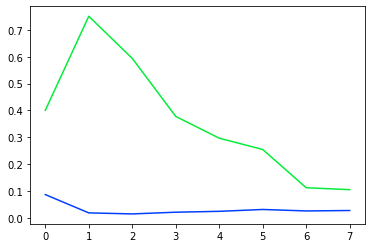

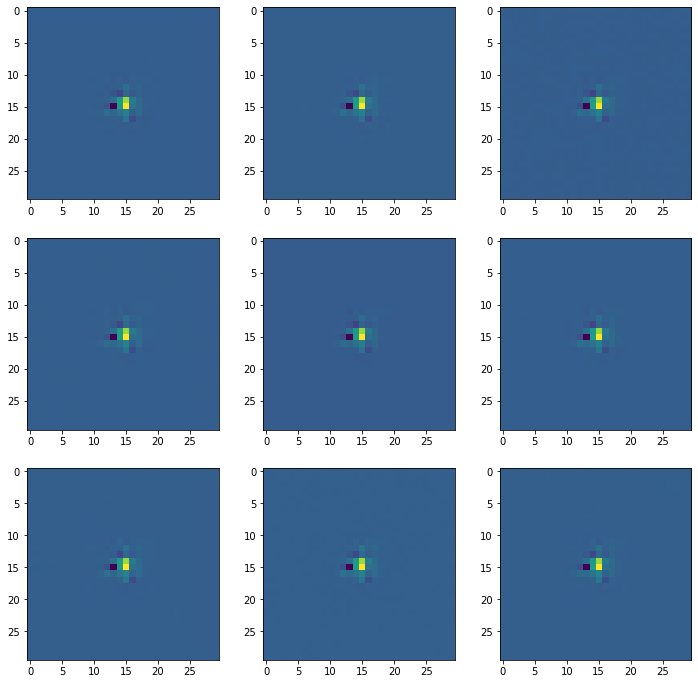

Starting epoch  8
664/664 [==============================] - 22s 33ms/step - loss: 0.1128 - accuracy: 0.9723


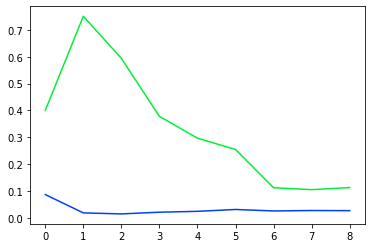

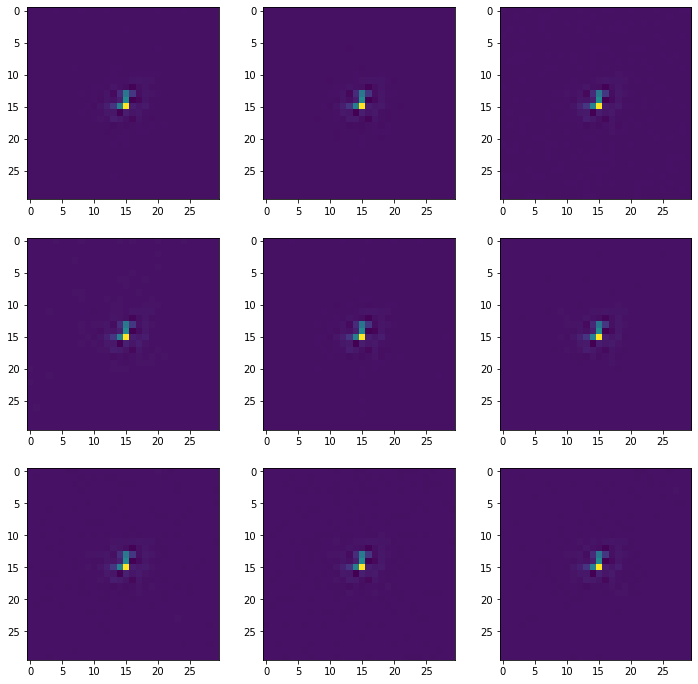

Starting epoch  9
664/664 [==============================] - 22s 33ms/step - loss: 0.0894 - accuracy: 0.9783


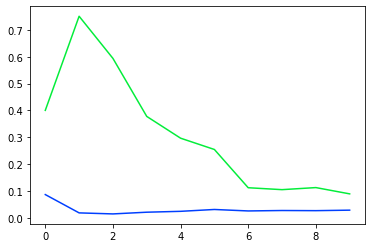

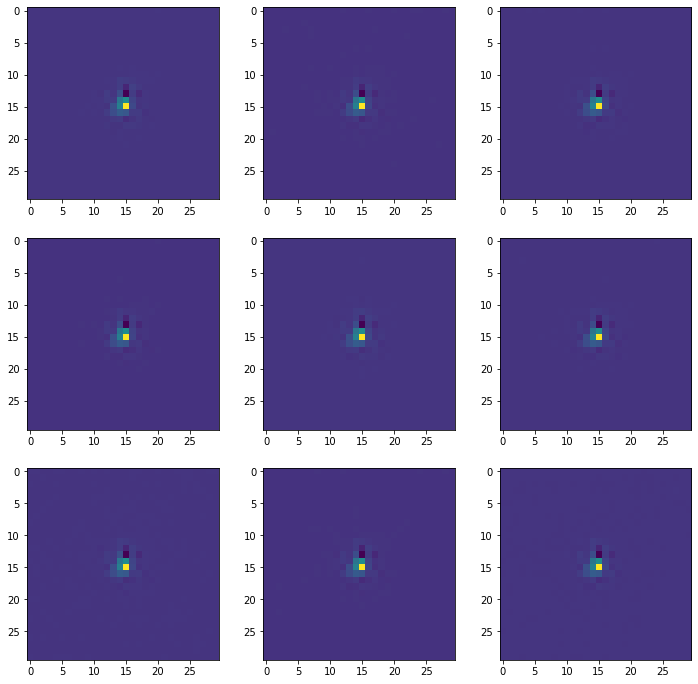

Starting epoch  10
664/664 [==============================] - 22s 33ms/step - loss: 0.0700 - accuracy: 0.9827


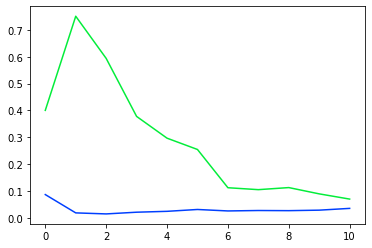

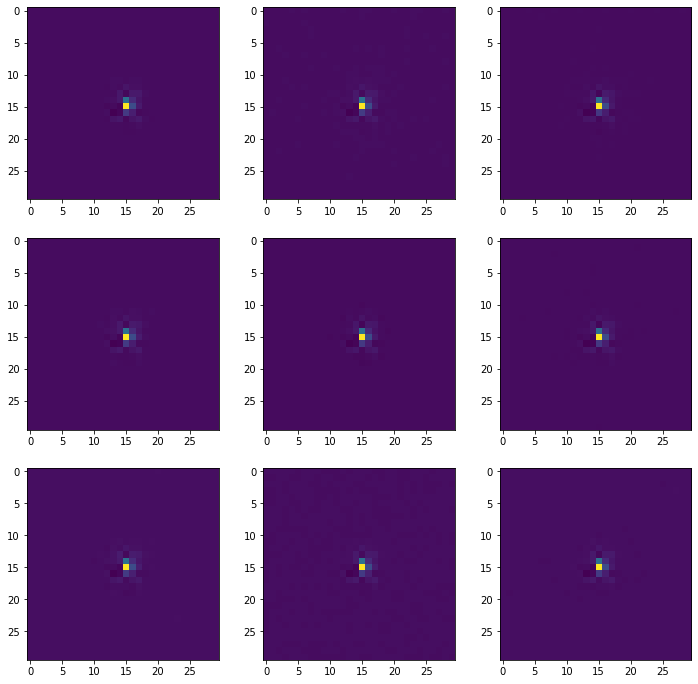

Starting epoch  11
664/664 [==============================] - 22s 33ms/step - loss: 0.0536 - accuracy: 0.9844


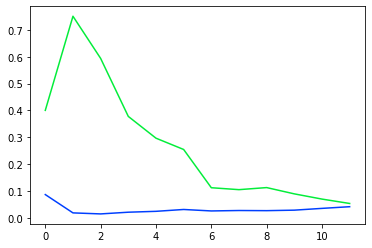

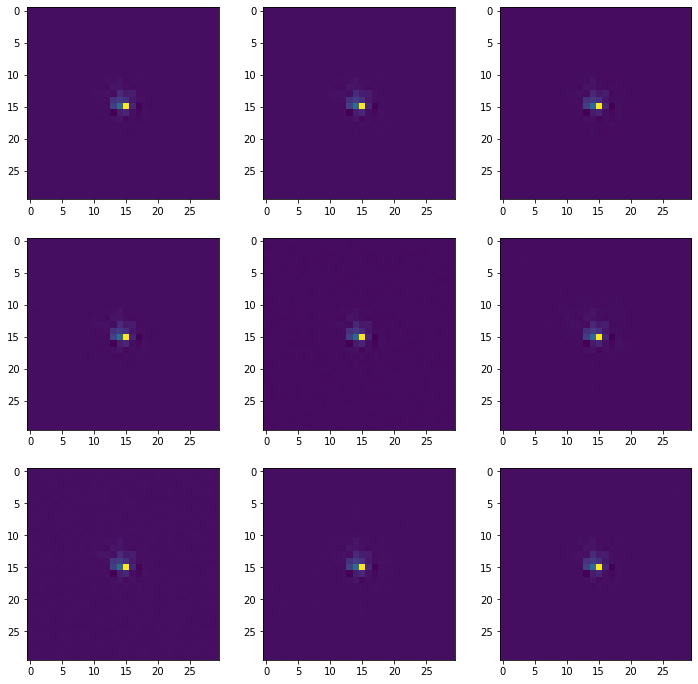

Starting epoch  12
664/664 [==============================] - 22s 32ms/step - loss: 0.0404 - accuracy: 0.9909


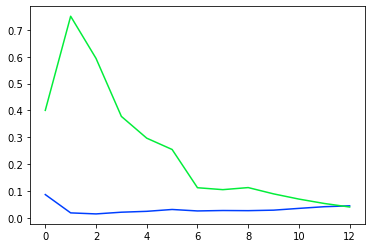

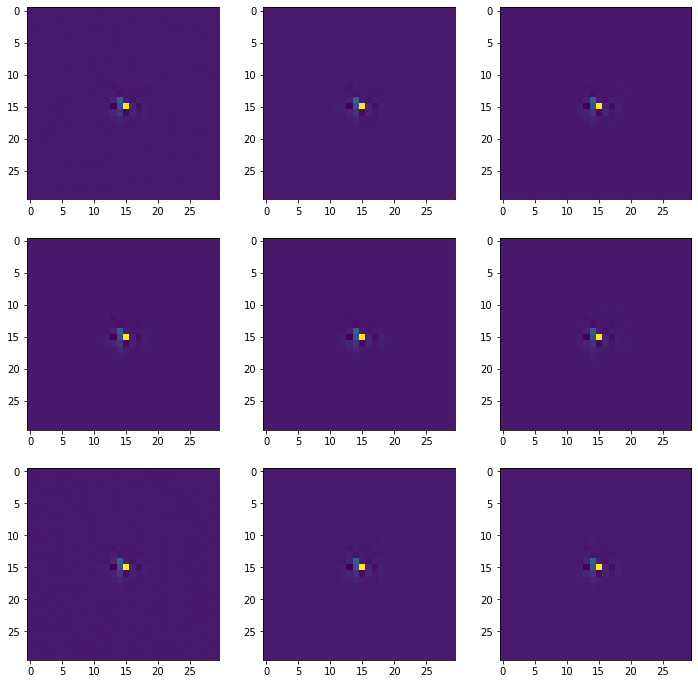

Starting epoch  13
664/664 [==============================] - 22s 33ms/step - loss: 0.0496 - accuracy: 0.9861


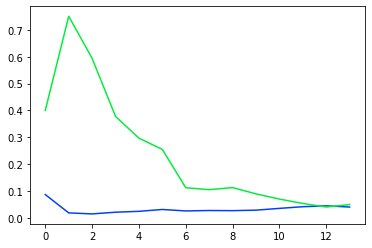

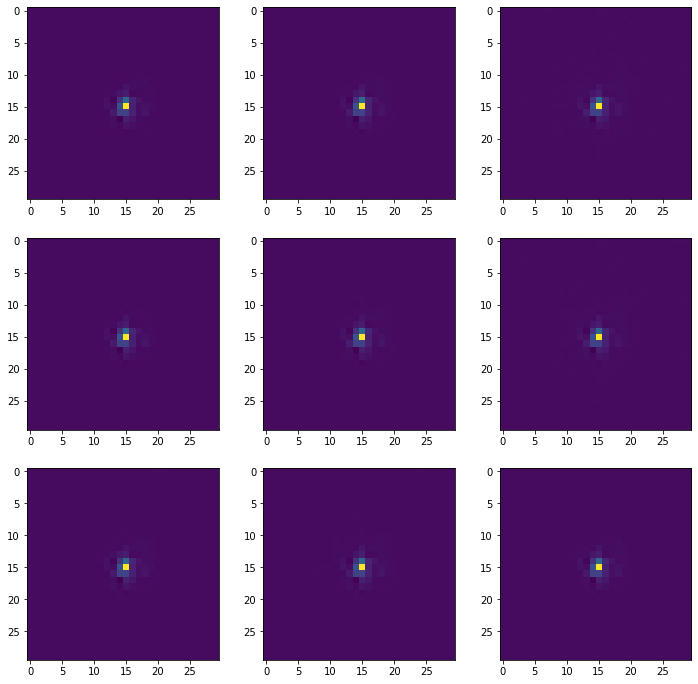

Starting epoch  14
664/664 [==============================] - 22s 33ms/step - loss: 0.0508 - accuracy: 0.9893


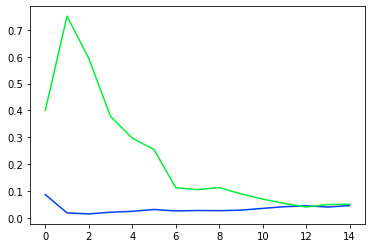

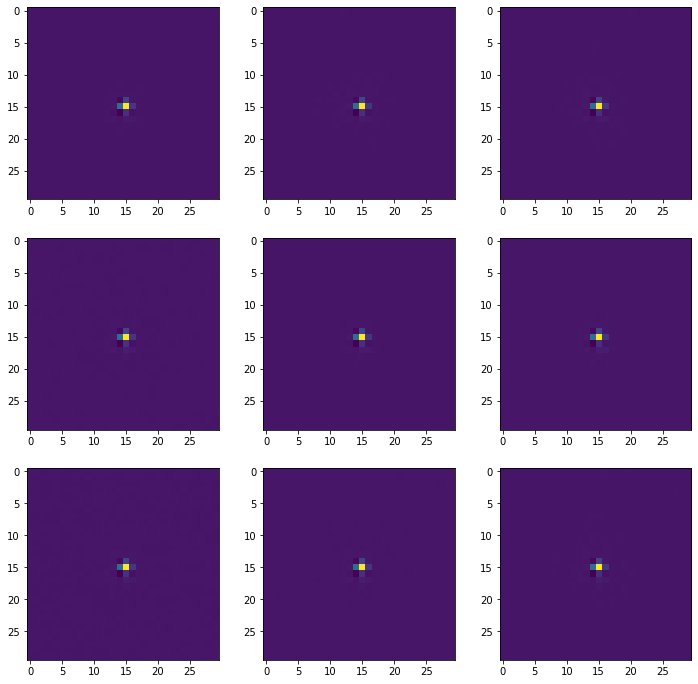

Starting epoch  15
664/664 [==============================] - 22s 33ms/step - loss: 0.0410 - accuracy: 0.9879


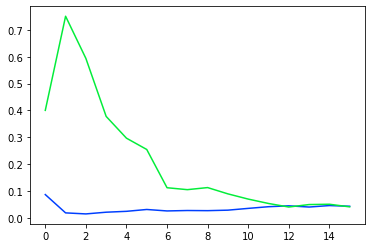

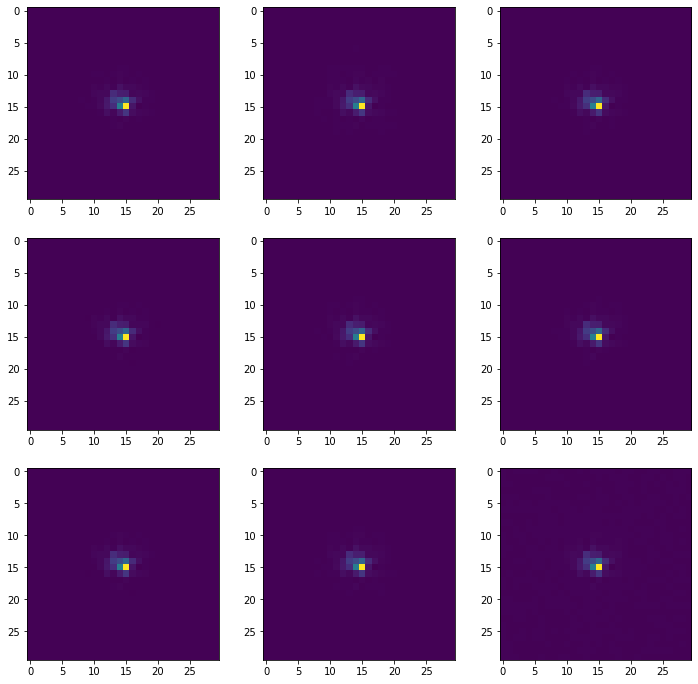

Starting epoch  16
664/664 [==============================] - 22s 33ms/step - loss: 0.0463 - accuracy: 0.9893


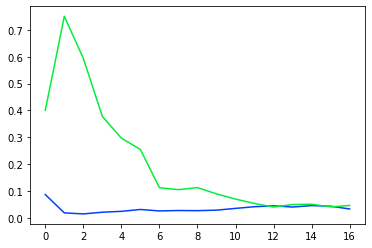

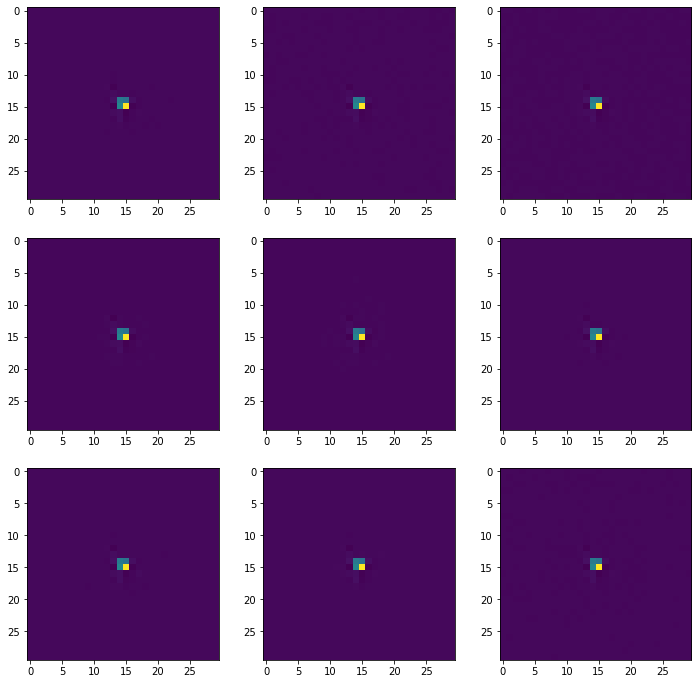

Starting epoch  17
664/664 [==============================] - 21s 32ms/step - loss: 0.0399 - accuracy: 0.9880


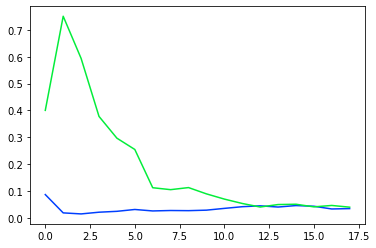

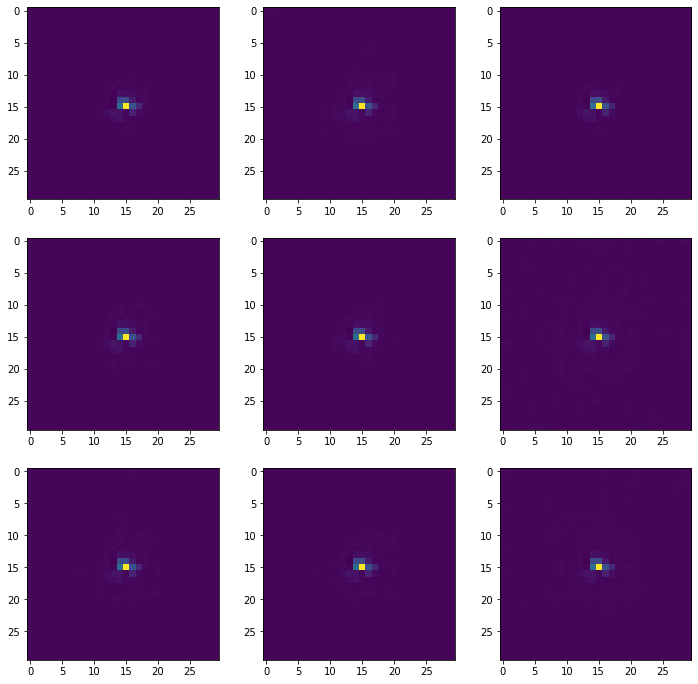

Starting epoch  18
664/664 [==============================] - 22s 33ms/step - loss: 0.0341 - accuracy: 0.9910


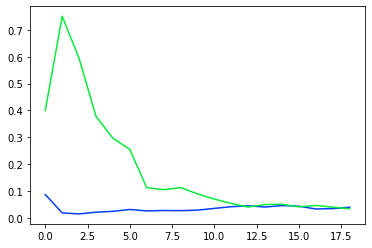

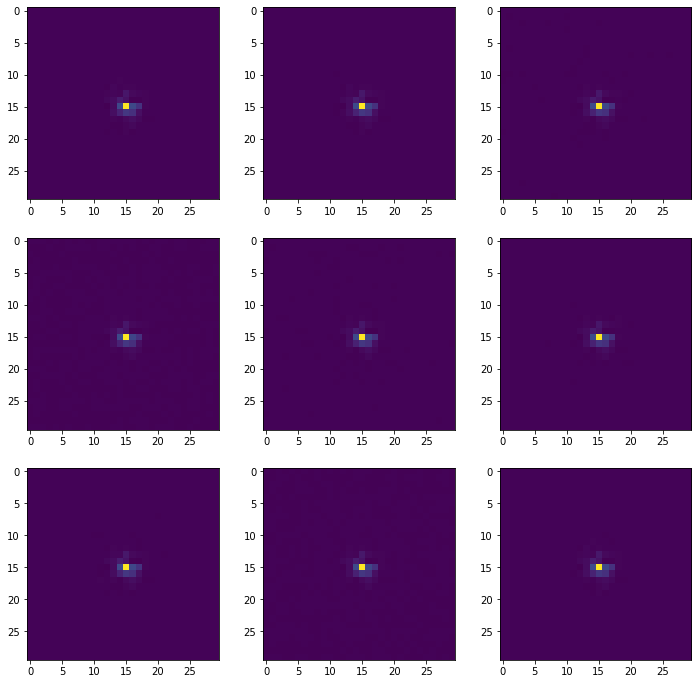

Starting epoch  19
664/664 [==============================] - 22s 33ms/step - loss: 0.0342 - accuracy: 0.9910


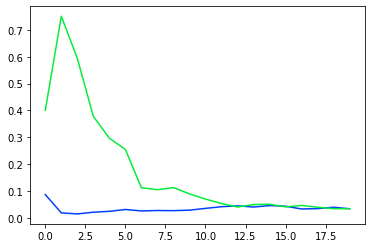

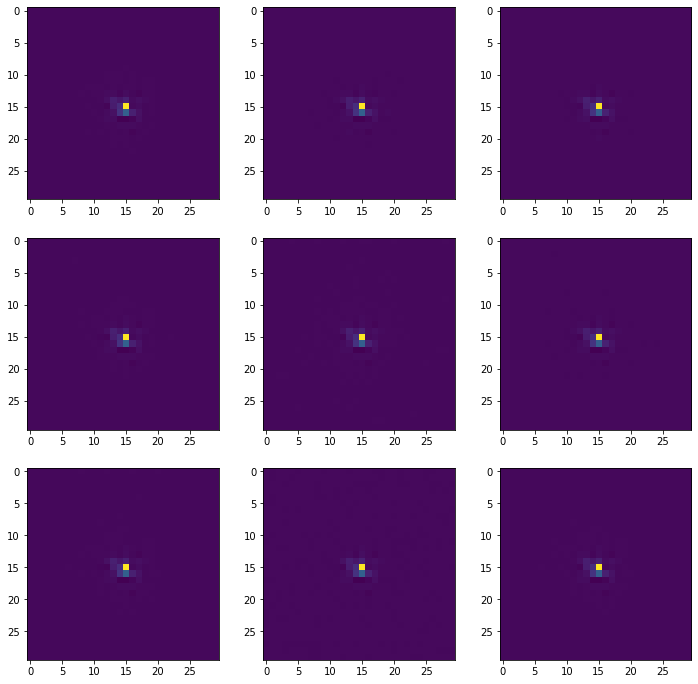

In [ ]:
#d_val_size = 0.15 # set validacion discriminador
D_BATCH_SIZE = 64
D_EPOCHS_PER_EPOCH = 1
    
FULL_EPOCHS = 20 # iteraciones para entrenamiento

#g_val_size = 0.15 #idem
G_BATCH_SIZE = 64 #idem
G_EPOCHS_PER_EPOCH = 1

samples_0 = train_d_input_data.shape[0] #samples que tenemos realmente
n_batches = int(samples_0 // D_BATCH_SIZE)

G_BATCHES = n_batches

#vamos a descartar muestras si hace falta para que los batches nos queden todos igual
samples = n_batches * D_BATCH_SIZE

N_GRAFICOS = 10




real_images = train_d_input_data[:samples] #nos aseguramos de que el numero de muestras sea divisible entre el batch_size

#Intercalamos de modo que cada batch tenga imagenes reales y falsas
true_labels = np.ones((n_batches, D_BATCH_SIZE, 1))
fake_labels = np.zeros((n_batches, D_BATCH_SIZE, 1))
disc_labels = disc_labels = np.concatenate([true_labels, fake_labels], axis = 1) # [n_batches,2*batch_size,1]
disc_labels = np.reshape(disc_labels, [-1, 1]) #shape [n_batches * 2 * batch_size]


#Para el generador solo vamos a introducir imagenes falsas, no hace falta intercalar
gen_labels = np.ones([G_BATCH_SIZE * G_BATCHES, 1])


batched_real_images = np.array(np.split(real_images, n_batches, axis = 0)) #shape: [n_batches, batch_size, width, height, 1]

z_graph = np.random.normal(mu,sigma,[N_GRAFICOS, g_input_length])


g_loss_list = []
d_loss_list = []
for i in range(FULL_EPOCHS):

    print("Starting epoch ", i)
    #Entrenamos el discriminador:
    
    z_noise = np.random.normal(mu,sigma,[samples, g_input_length]) #creamos ruido para generar el dataset
    fake_images = model_g.predict(z_noise)
    batched_fake_images = np.array(np.split(fake_images, n_batches, axis = 0))

    disc_input = np.concatenate([batched_real_images, batched_fake_images], axis = 1) #shape: [n_batches, 2 * batch_size, width, heigth, 1] 
    disc_input = np.reshape(disc_input, [-1] + list(disc_input.shape[2:])) #shape [n_batches * 2 * batch_size, width, height, 1]

    d_history = model_d.fit(disc_input, disc_labels, batch_size=D_BATCH_SIZE*2, epochs=D_EPOCHS_PER_EPOCH, verbose=1)
    #shape: [N_samples, latent_dims]
    
    
    
        
    #Entrenamos el generador: 
    z_noise = np.random.normal(mu,sigma,[G_BATCH_SIZE * G_BATCHES, g_input_length]) #creamos ruido 

    g_history = gan.fit(z_noise, gen_labels, batch_size=G_BATCH_SIZE, epochs=G_EPOCHS_PER_EPOCH , verbose=1)
    
    
    #guardamos las loss medias
    
    d_loss_list.append(d_history.history["loss"][-1])
    g_loss_list.append(g_history.history["loss"][-1])

    plt.figure(i)
    plt.plot(range(i+1), d_loss_list,label='log_loss_discriminator')
    plt.plot(range(i+1), g_loss_list,label='log_loss_generator')

    plt.show()


    #Hacemos unos plots
 #creamos ruido para generar el dataset
    fake_images = np.array(model_g.predict(z_graph))
    plot_energy_grids(np.reshape(fake_images, [-1,30,30]), name="_fake_images_" + str(i))

    X_fake = model_g.predict(z_noise)
    energy_fakes = np.array(X_fake[0:42500])



In [ ]:
print(d_loss_list)

In [ ]:
import statistics 
import math


def compute_avg_energy(reshapaed_energy_grids):
    total_energy = 0
    for counter, image in enumerate(reshapaed_energy_grids):
        total_energy += sum(sum(image))
    total_energy = total_energy/50000
    print("The average energy per image is: " + str(total_energy))
    return total_energy

def energia_media(energias):
    e_m = np.mean(energias, axis =(1,2,3))
    return e_m





def find_baricenter(image):
    baricenter = [0,0]
    total_energy = sum(sum(image))
    for row, energy_row in enumerate(image):
        for column, energy in enumerate(energy_row):
            if energy > 0.0:
                baricenter[0] += (row+1)*energy/total_energy
                baricenter[1] += (column+1)*energy/total_energy
    #print("Image energy: " + str(total_energy))
    #print("Image baricenter: " + str(baricenter))
    return baricenter, total_energy

def iterate_image(distances, image):
    baricenter, total_energy = find_baricenter(image)
    for row, energy_row in enumerate(image):
        for column, energy in enumerate(energy_row):
            if energy > 0.0:
                #print("The energy in the cell " + str(row) + "," + str(column) + " is " + str(energy))
                x = math.pow((row+1)*energy/total_energy - baricenter[0],2)*energy/total_energy
                y = math.pow((column+1)*energy/total_energy - baricenter[1],2)*energy/total_energy
                distances.append(math.sqrt(x + y))

def compute_avg_distance(reshapaed_energy_grids):
    avg_distances_per_images = []
    sd_distances_per_images = []
    for counter, image in enumerate(reshapaed_energy_grids):
        if counter%5000 == 0.0:
            print("Computing image number " + str(counter) + " of " + str(len(reshapaed_energy_grids)))
        distances = []
        for image_direction in [image, np.flip(image), np.transpose(image), np.flip(np.transpose(image))]:
            iterate_image(distances, image_direction)

        avg_distances_per_images.append(sum(distances)/len(distances))
        sd_distances_per_images.append(statistics.stdev(distances))

    avg_whole_dataset_distances = sum(avg_distances_per_images)/len(avg_distances_per_images)
    sd_distances_per_images_squared = []
    for sd in sd_distances_per_images:
        sd_distances_per_images_squared.append(math.pow(sd,2))
    avg_whole_dataset_sd = math.sqrt(sum(sd_distances_per_images_squared))/len(avg_distances_per_images)
    
    print("The avg distance is " + str(avg_whole_dataset_distances) + " cells with an error of " + str(avg_whole_dataset_sd) + " cells.")
    print("The avg distance is " + str(avg_whole_dataset_distances*2) + " cms with an error of " + str(avg_whole_dataset_sd*2) + " cms.")


In [ ]:
def get_weighted_distances(image):
    #image shape [batch_size, height, width, 1]
    total_energy = np.sum(image, axis = (1,2,3), keepdims = True) #shape = [batch_size, 1, 1, 1] (the total energy of each image) 
    normalized_energies = image / total_energy #it is efectively normalized

    x_grid, y_grid = np.meshgrid(np.linspace(-1, 1, image.shape[1]), np.linspace(-1, 1, image.shape[2])) #shapes [height, width]

    #x grid matrix is: (but larger of course, not 4 by 4)
    #-1 , 0.5, 0, 0.5, 1
    #-1 , 0.5, 0, 0.5, 1
    #-1 , 0.5, 0, 0.5, 1
    #-1 , 0.5, 0, 0.5, 1
    #-1 , 0.5, 0, 0.5, 1
    #(Like the value of each column but from -1 to 1 instead of 0 to n_columns, that way we dont need to loop!)

    # y grid is the same but transposed
                                                    
    x_grid = np.repeat(np.reshape(x_grid, [1,image.shape[1],image.shape[2],1]), image.shape[0], axis = 0) # we reshape [batch_size, height, width, 1] (matching with images!)
    y_grid = np.repeat(np.reshape(y_grid, [1,image.shape[1],image.shape[2],1]), image.shape[0], axis = 0)
    
    x_centers = np.sum(x_grid * normalized_energies, axis = (1,2,3), keepdims = True) #shape = [batch_size, 1, 1, 1] (More or less matching images)
    y_centers = np.sum(y_grid * normalized_energies, axis = (1,2,3), keepdims = True)

    x_centroid_dist_grids = x_grid - x_centers #substract the x coordinates of the center (to get the centroids)
    y_centroid_dist_grids = y_grid - y_centers

    

    centroid_dist_grids = np.sqrt(x_centroid_dist_grids**2 + y_centroid_dist_grids**2) #shape [batch_size, height, width, 1] (matching with images)
    #sqrt(x_centroid_dist_grids^2 + y_centroid_dist_grids^2) is the distance/radius from the center of mass r(x,y)
    
    
    weighted_distances = normalized_energies * centroid_dist_grids #shape [batch_size, height, width, 1] energy_density(x,y) * r(x,y) (we will sumate everything later to emulate the integral)

    total_weighted_distances = np.sum(weighted_distances, axis = (1,2,3)) #[batch_size] 
    #we dont need to calculate an average since we normalized the images already and weighted them with the normalized weights
    
    return total_weighted_distances #The result of the integral for each image

In [ ]:
def compare_two_corpus(corpus_1, corpus_2):
  #Each corpus must be of shape [batch_size, height, width, 1] (I'm not sure if they need to have the same batch size each, it may work anyway)
    corpus_1_dist = get_weighted_distances(corpus_1)
    corpus_2_dist = get_weighted_distances(corpus_2)

    plt.figure()
    
    plt.hist([corpus_1_dist, corpus_2_dist], density = True, label = ["fake_energy", "real_energy"])
    plt.legend()
    plt.xlabel('a.u')
    plt.ylabel('Frecuencia')
    plt.show()

In [ ]:
def compare_two_energies(corpus_1, corpus_2):
  #Each corpus must be of shape [batch_size, height, width, 1] (I'm not sure if they need to have the same batch size each, it may work anyway)
    corpus_1_dist = energia_media(corpus_1)
    corpus_2_dist = energia_media(corpus_2)

    plt.figure()
    
    plt.hist([corpus_1_dist, corpus_2_dist], density = True, label = ["fake_energy", "real_energy"] )
    plt.legend()
    plt.xlabel('a.u')
    plt.ylabel('Frecuencia')
    plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


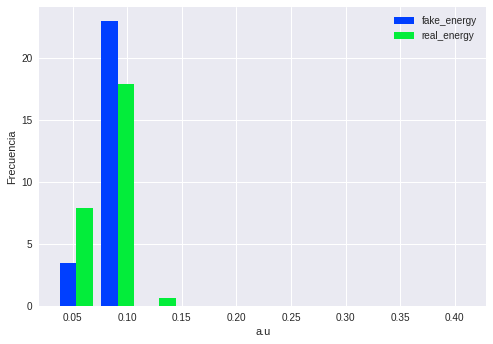

In [ ]:
plt.style.use('seaborn-bright')
compare_two_corpus(energy_fakes,train_d_input_data)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


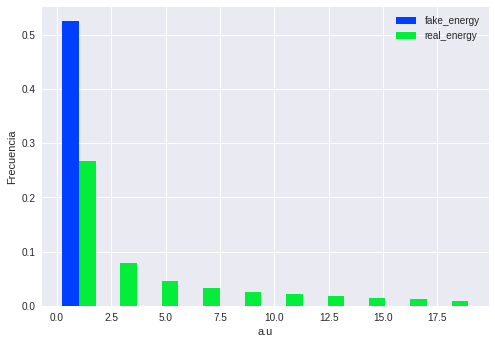

In [ ]:
compare_two_energies(energy_fakes, train_d_input_data)

In [ ]:
energy_fakes= energy_fakes.reshape(energy_fakes.shape[:3])
compute_avg_distance(energy_fakes)

Computing image number 0 of 42496
Computing image number 5000 of 42496
Computing image number 10000 of 42496
Computing image number 15000 of 42496
Computing image number 20000 of 42496
Computing image number 25000 of 42496
Computing image number 30000 of 42496
Computing image number 35000 of 42496
Computing image number 40000 of 42496
The avg distance is 0.3579760521910553 cells with an error of 0.003596259153792643 cells.
The avg distance is 0.7159521043821107 cms with an error of 0.007192518307585286 cms.


In [ ]:
train_d_input_data.mean()

4.014176

In [ ]:
energia_media(train_d_input_data)

array([ 1.5924236 ,  0.6077033 , 15.140637  , ...,  0.95875746,
        1.6434891 ,  0.49598622], dtype=float32)